# Titanica Survival prediction
<br/>
Based on the tutorial made by [Patrick Triest](http://www.kdnuggets.com/2016/07/titanic-machine-learning-guide-part-1.html)
<br/><br/>
In this jupyter notebook we are going to follow the tutorial made by Patrick Triest but adding a feature selection algorithm.
<br/><br/>
By Carlos Martinez

In [2]:
from itertools import combinations
from sklearn import datasets, svm, tree, preprocessing
from sklearn.base import clone
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.contrib import learn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sklearn.ensemble as ske
import tensorflow as tf

%matplotlib inline

## SBS algorithm for feature selection
Code implementation taken from the book Python machine learning by Sebastian Raschka.

In [3]:
class SBS():
    def __init__(self, estimator, k_features, 
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=self.test_size,
                                                            random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, 
                          X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## Titanic dataset
Dataset source: [Biostat titanic dataset](http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets/titanic3.xls)
<br/>
This dataset contains the information of 1308 passangers and contains the following labels:

* pclass    -> Passenger class (1st, 2nd and 3rd).
* survived  -> If the passenger survived (0 = No, 1 = Yes).
* name      -> Passenger's name.
* sex       -> Passenger's gender (0 = Female, 1 = Male).
* age       -> Passenger's age.
* sibsp     -> Number of siblings and/or spouses aboard.
* parch     -> Number of parents and/or children aboard.
* ticket    -> Ticket number.
* fare      -> Passenger fare.
* cabin     -> Cabin number.
* embarked  -> Where does the passenger embarked (Cherbourg, Queenstown or Southhampton).
* boat      -> Number of lifeboat, if survided, the passenger where embarked on.
* body      -> Body number, assigned if the body was recovered.
* home.dest -> Coming from / going to locations.

## Reading and looking at the dataset

In [4]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index__col=None, na_values=['NA'])
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Obtaining some information from the dataset
<br/>
Here we are going to look at some dataset statistics.

In [5]:
titanic_df['survived'].mean()

0.3819709702062643

The survival rate was very low generaly speaking, like nearly four of every ten passengers survived.

In [6]:
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


Now grouping by passenger class we can see that the one with the highest survival rate was the first class and the lowest was the third class, that's understandable because of their rigth to a lifeboat.

In [7]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

Grouping by class and sex we can see that nearly all of the first class female passengers survived, something similar for the second class but the third did'nt run with that luck. We can also observe that the men had a bad time, that can be said because the survival rate of any of the mens classes population had more than 35 percent survival rate.

## Eliminating probable useless attributes and rows with missing values

In [8]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

We observe that the labes boat, body and cabin have a lot of missing values.
<br/>
* The cabin number could be relevant because the proximity to a lifeboat but unfortunately there a too many missing values so it can be discarded.
* The boat number is not relevant because who cares if the passenger was aboard the lifeboat number twenty.
* The body number is not useful because if the passenger have one that means that they did not survived.

We also see that other information that migth not be relevant can be from the labels name, ticket and home/dest.
Maybe only the name because the passanger could be an influential person but that would require additional information about the person.
<br/>
So we are going to drop all of these attributes and delete the rows with missing values, with that we're going to have a dataset full of information.

In [9]:
titanic_df = titanic_df.drop(['boat', 'body', 'cabin', 'home.dest', 'name', 'ticket'], axis=1)
titanic_df = titanic_df.dropna()
titanic_df.count()

pclass      1043
survived    1043
sex         1043
age         1043
sibsp       1043
parch       1043
fare        1043
embarked    1043
dtype: int64

Now we have 1043 records to work with.

## Encoding labels

First we take a look at the data.

In [10]:
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


The labels sex and embarked must be encoded so the learning algorithms does'nt have a bad time.

In [11]:
label_encoder = preprocessing.LabelEncoder()
titanic_df.sex = label_encoder.fit_transform(titanic_df.sex)
titanic_df.embarked = label_encoder.fit_transform(titanic_df.embarked)
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,2
1,1,1,1,0.9167,1,2,151.5500,2
2,1,0,0,2.0000,1,2,151.5500,2
3,1,0,1,30.0000,1,2,151.5500,2
4,1,0,0,25.0000,1,2,151.5500,2


The dataset is nearly ready, we may now apply a feature selection algorithm to see if we can discard another attribute.

## Creating the standarized training and testing datasets

In [12]:
X, y = titanic_df.drop(['survived'], axis=1).values, titanic_df['survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

stdsc = preprocessing.StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Now we are ready for the feature selection process using the standarized dataset.

## Feature selection

We are going to use the algorithm declared at the beginning of the notebook to see which of the attributes are the most relevant according to it.

In [13]:
titanic_df.drop(['survived'], axis=1).head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1,0,29.0000,0,0,211.3375,2
1,1,1,0.9167,1,2,151.5500,2
2,1,0,2.0000,1,2,151.5500,2
3,1,1,30.0000,1,2,151.5500,2
4,1,0,25.0000,1,2,151.5500,2


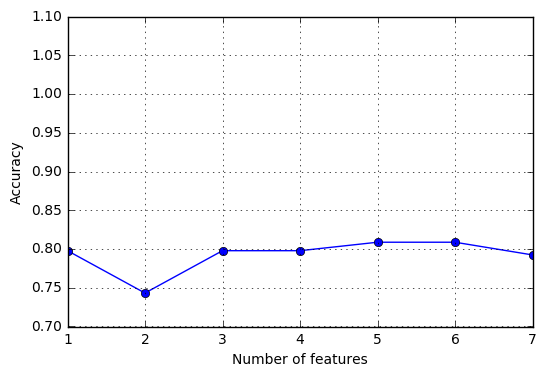

In [14]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

#Showing the results
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

According to this results the best score is obtained when three features are used but in this case we are going to use the features from the best and the second best accuracy scores.

In [15]:
k6 = list(sbs.subsets_[1])
k5 = list(sbs.subsets_[2])
print(titanic_df.drop(['survived'], axis=1).columns[0:][k6])
print(titanic_df.drop(['survived'], axis=1).columns[0:][k5])

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare'], dtype='object')
Index(['pclass', 'sex', 'age', 'sibsp', 'parch'], dtype='object')


We can see that the attribute that is discarded in both cases is embarked and the one eliminated in k5 is also fare, now we need to test some classifiers using all the attributes and the ones given by the algorithm to make a comparison between the three.

## Creating the new datasets and the scoring function
<br/>
We already have ourt test and train datasets but now we need to create the ones with the selected features, here X_train and X_test will be the original ones while X_fs_5 and X_fs_6 will have less features.

In [16]:
#X_train and X_test already exist
stdsc = preprocessing.StandardScaler()
#For 6 features
X_fs_6, y_fs_6 = titanic_df.drop(['survived','embarked'], axis=1).values, titanic_df['survived'].values
X_fs_6_train, X_fs_6_test, y_fs_6_train, y_fs_6_test = train_test_split(X_fs_6, y_fs_6, test_size=0.3, random_state=42)

X_fs_6_train_std = stdsc.fit_transform(X_fs_6_train)
X_fs_6_test_std = stdsc.transform(X_fs_6_test)
#For 5 features
X_fs_5, y_fs_5 = titanic_df.drop(['survived', 'fare','embarked'], axis=1).values, titanic_df['survived'].values
X_fs_5_train, X_fs_5_test, y_fs_5_train, y_fs_5_test = train_test_split(X_fs_5, y_fs_5, test_size=0.3, random_state=42)

X_fs_5_train_std = stdsc.fit_transform(X_fs_5_train)
X_fs_5_test_std = stdsc.transform(X_fs_5_test)

In [17]:
def test_classifier(classifier):
    classifier.fit(X_train_std, y_train)
    print('Without feature selection')
    print('Train accuracy: {:.5f}'.format(classifier.score(X_train_std, y_train)))
    print('Test accuracy: {:.5f}\n'.format(classifier.score(X_test_std, y_test)))
    
    classifier.fit(X_fs_6_train_std, y_fs_6_train)
    print('With feature selection (6 features)')
    print('Train accuracy: {:.5f}'.format(classifier.score(X_fs_6_train_std, y_fs_6_train)))
    print('Test accuracy: {:.5f}\n'.format(classifier.score(X_fs_6_test_std, y_fs_6_test)))
    
    classifier.fit(X_fs_5_train_std, y_fs_5_train)
    print('With feature selection (5 features)')
    print('Train accuracy: {:.5f}'.format(classifier.score(X_fs_5_train_std, y_fs_5_train)))
    print('Test accuracy: {:.5f}'.format(classifier.score(X_fs_5_test_std, y_fs_5_test)))

# Science Kit Learn

### Decision Tree Classifier

In [18]:
clf_dt = tree.DecisionTreeClassifier(max_depth=3)
test_classifier(clf_dt)

Without feature selection
Train accuracy: 0.82877
Test accuracy: 0.78594

With feature selection (6 features)
Train accuracy: 0.82877
Test accuracy: 0.78594

With feature selection (5 features)
Train accuracy: 0.81781
Test accuracy: 0.77955


### Random Forest Classifier

In [19]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Without feature selection
Train accuracy: 0.98493
Test accuracy: 0.74121

With feature selection (6 features)
Train accuracy: 0.98356
Test accuracy: 0.73802

With feature selection (5 features)
Train accuracy: 0.92329
Test accuracy: 0.75719


### Gradient Boost Classifier

In [20]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Without feature selection
Train accuracy: 0.86575
Test accuracy: 0.78275

With feature selection (6 features)
Train accuracy: 0.86575
Test accuracy: 0.79233

With feature selection (5 features)
Train accuracy: 0.85616
Test accuracy: 0.79233


### Voting Classifier

In [21]:
clf_vc = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(clf_vc)

Without feature selection
Train accuracy: 0.87397
Test accuracy: 0.78275

With feature selection (6 features)
Train accuracy: 0.87808
Test accuracy: 0.78594

With feature selection (5 features)
Train accuracy: 0.86849
Test accuracy: 0.79553


As we can see the best option is to use a voting classifier because it takes in account all of the classifiers and uses a 'democratic' system in which all the votants are 'persons' that know abbout the topic. For this cases using less fatures yield better results according to the SBS prediction except for the decision tree classifier that broke this rule. In this specific case, the best option is to use a voting classifier with 5 features. Now we will use a neural network to test our results

# Tensor Flow

### Neural Networks
Now we are going to test the three cases using a simple neural network from the tensor flow library based on the example given by [Illia Polosukhin](https://medium.com/@ilblackdragon/tensorflow-tutorial-part-2-9ffe47049c92#.5joy6sv88)

In [22]:
import warnings
warnings.filterwarnings('ignore')

print('Without feature selection')
classifier = learn.DNNClassifier(hidden_units=[10, 20, 10],
                                 n_classes=2,
                                 feature_columns=learn.infer_real_valued_columns_from_input(X_train_std),
                                 optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05))

classifier.fit(X_train_std, y_train, batch_size=128, steps=500)
print("Train accuracy: {:.5f}".format(accuracy_score(classifier.predict(X_train_std), y_train)))
print("Test accuracy: {:.5f}\n".format(accuracy_score(classifier.predict(X_test_std), y_test)))

print('With feature selection (6 features)')
classifier_6 = learn.DNNClassifier(hidden_units=[10, 20, 10],
                                 n_classes=2,
                                 feature_columns=learn.infer_real_valued_columns_from_input(X_fs_6_train_std),
                                 optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05))
classifier_6.fit(X_fs_6_train_std, y_fs_6_train, batch_size=128, steps=500)
print("Train accuracy: {:.5f}".format(accuracy_score(classifier_6.predict(X_fs_6_train_std), y_fs_6_train)))
print("Test accuracy: {:.5f}\n".format(accuracy_score(classifier_6.predict(X_fs_6_test_std), y_fs_6_test)))

print('With feature selection (5 features)')
classifier_5 = learn.DNNClassifier(hidden_units=[10, 20, 10],
                                 n_classes=2,
                                 feature_columns=learn.infer_real_valued_columns_from_input(X_fs_5_train_std),
                                 optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05))
classifier_5.fit(X_fs_5_train_std, y_fs_5_train, batch_size=128, steps=500)
print("Train accuracy: {:.5f}".format(accuracy_score(classifier_5.predict(X_fs_5_train_std), y_fs_5_train)))
print("Test accuracy: {:.5f}".format(accuracy_score(classifier_5.predict(X_fs_5_test_std), y_fs_5_test)))

Without feature selection


Train accuracy: 0.83151
Test accuracy: 0.76358

With feature selection (6 features)


Train accuracy: 0.83425
Test accuracy: 0.75080

With feature selection (5 features)
Train accuracy: 0.83014
Test accuracy: 0.76038


we see that the neural network with the best test score was the one that used all of the features and the second best was the one that used 5 so maybe using all features except fare would give a better score. In general the neural network approach was only better in testing results than the random forest algorithm.

## Conclusion
<br/>
This dataset is interesting because it comes from a real world event in which we can see that the policy 'women and children first' has a meaning also it allows new machine learning users to see some preprocessing tasks like discard features by hand (in this case the elimination of some features are obvious like the 'body nuumber'), deleting rows with missing values, encoding labels and using a feature selection algorithm for reducing the problem dimension. From all of the classifiers the best was (not taking into account the voting one) the gradient boost and the worst was the random forest considering the random state for test and train split with a value of 42, using another random state would give different performance values and other results in the feature selection task.
If whe create a hypotetical passenger and we use the voting classifier we will have a 79.55% of confidence of the fate given by the classifier.